# Tutorial 01: Environment, Safety, and Robustness Primer

**Author:** Ming Jin | [jinming.tech](https://jinming.tech) | jinming@vt.edu  
**Series:** Safe and Robust RL for Power and Energy Systems | [Full References](https://github.com/username/repo/blob/main/REFERENCES.md)


This notebook introduces the EVCharging environment, exploring its observation/action spaces, safety constraints, reward design, robustness features, and control modes.

![EV Charging Station](https://images.unsplash.com/photo-1593941707882-a5bba14938c7?w=1200&h=400&fit=crop)
*Modern EV charging infrastructure presents complex decision-making challenges*


## Background and Motivation

Electric Vehicle charging optimization sits at the intersection of power systems, transportation, and sustainability. This tutorial explores a realistic charging environment based on [ACN-Sim from Caltech](https://ev.caltech.edu/simulator), using real-world data from university charging garages.

The core challenge: How do we charge multiple vehicles efficiently while respecting physical network limits, minimizing carbon emissions during high-pollution periods, and maintaining profitability? This environment provides a sandbox to explore these trade-offs.


### Objectives

After completing this tutorial, you will understand:
- The structure and meaning of observations (demands, departures, emissions forecasts)
- How actions translate to physical charging rates
- Network safety constraints and their enforcement
- The multi-objective reward function design
- Robustness testing through noise injection

### Cost Convention (Per-step vs Cumulative)

We treat safety as a per-step cost $c_t$, while constraints are enforced on episode totals.

- Per-step safety cost:
  $$c_t = \max\big(0, \; \lVert \mathbf{I}^{\text{grid}}_t \rVert - \mathbf{b}^{\text{limit}} \big).$$

- Episode cumulative cost:
  $$C^{(\text{ep})} = \sum_{t=0}^{T-1} c_t.$$

- Constraint enforced in experiments:
  $$\mathbb{E}[\,C^{(\text{ep})}\,] \le d.$$

Notes used across all tutorials:
- The environment logs a cumulative series `info['reward_breakdown']['excess_charge']` within an episode.
- Utilities/wrappers derive per-step `info['cost']` by differencing that series.
- Algorithms learn from per-step costs but check safety using the episode total against the limit $d$.
- Reported `mean_cost` is the mean of per-episode totals, aligning evaluation and training.

### Prerequisites and Setup


In [1]:
import sys
from pathlib import Path

try:
    nb_dir = Path(__file__).parent
except NameError:
    nb_dir = Path.cwd()

repo_root = nb_dir.parent  # tutorials/ -> repo root
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Optional imports with graceful fallback
try:
    import seaborn as sns
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
except ImportError:
    print("Note: seaborn not installed, using default matplotlib style")
    plt.style.use('default')

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    print("Note: CVXPY not installed, some optimization demos will be skipped")

# Import EV charging components
from envs.evcharging import EVChargingEnv, GMMsTraceGenerator, RealTraceGenerator
from envs.evcharging import MultiAgentEVChargingEnv
from envs.evcharging.env import magnitude_constraint
from envs.evcharging.utils import site_str_to_site
from data.load_moer import MOERLoader, load_monthly_moer

# Import utilities from new structure
from tutorials.utils import (
    # Common
    wrap_policy, extract_from_obs, solve_cvx_with_fallback, create_ev_env,
    # EV-specific
    evaluate_policy, sweep_noise, plot_robustness_heatmap,
    plot_action_distribution, save_evaluation_results,
    load_evaluation_results, save_timeseries, load_timeseries,
    run_scenario_sweep, plot_algorithm_comparison_matrix,
    # Diagnostics
    pilot_signals_df, constraint_slack_t, constraint_slack_series,
    plot_slack_from_env, interactive_critical_timeline, 
    policy_behavior_fingerprint,
    # Notebook
    show, show_metrics, quick_plot,
    # Shared planning-friendly evaluation config
    PlanningEvalConfig, get_planning_eval_env_fn,
)

# Style control
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Global density toggle for tutorial demos
TUTORIAL_DENSE = True

### Note: Tutorial density mode

This tutorial enables a denser, more demonstrable scenario when using the shared
environment factory `create_ev_env()` by passing `dense_mode=True` (default 3x sessions).
This improves interactivity and reduces flat segments during short horizons.
For realistic benchmarking and research experiments, set `dense_mode=False`.

## Evaluation Environment Settings (Shared Across Tutorials)

We use a common evaluation configuration to make planning advantages visible and comparisons fair across notebooks.
These settings reduce oversaturation, emphasize carbon timing, and penalize violations more strongly.

Settings used here (and recommended for other tutorials):
- Density multiplier: 3.0
- Violation weight: 5.0
- Carbon multiplier: 3.0
- Departure extension (steps): 24 (~2 hours optimistic extension)
- Forecast error enabled: True (modest growth with horizon)
- Demand charge: Disabled by default (can be enabled per experiment)

In [ ]:
EVAL_CFG = PlanningEvalConfig(
    density_multiplier=3.0,
    violation_weight=5.0,
    carbon_multiplier=3.0,
    departure_extension_steps=24,
    enable_forecast_error=True,
    enable_demand_charge=False,
    demand_charge_per_kw=200.0,
    seed=42,
)

# Build an evaluation env factory (single-agent) using the shared helper
eval_env_fn = get_planning_eval_env_fn(
    EVAL_CFG,
    site='caltech',
    date_range=('2019-05-01', '2019-08-31'),
    flatten=False,
    moer_forecast_steps=36,
    project_action_in_env=False,
    dense_mode=TUTORIAL_DENSE,
)

show("section: Evaluation Environment Settings (Shared)")
show_metrics({
    'Density multiplier': EVAL_CFG.density_multiplier,
    'Violation weight': EVAL_CFG.violation_weight,
    'Carbon multiplier': EVAL_CFG.carbon_multiplier,
    'Departure ext (steps)': EVAL_CFG.departure_extension_steps,
    'Forecast error enabled': EVAL_CFG.enable_forecast_error,
    'Demand charge enabled': EVAL_CFG.enable_demand_charge,
    'Demand charge $/kW': EVAL_CFG.demand_charge_per_kw if EVAL_CFG.enable_demand_charge else 0.0,
}, title='Standardized Evaluation Settings')

# You can pass `eval_env_fn` to evaluation helpers, e.g.,
# mean_ret, std_ret, mean_cost, metrics = evaluate_policy(policy_fn, eval_env_fn, episodes=10, ...)

## Section 1: Environment Deep Dive

### Creating the Environment

We'll use synthetic traces from Gaussian Mixture Models (GMMs) for reproducibility. These models are trained on real charging data and generate realistic arrival/departure patterns.

In [2]:
# Initialize event generator with GMM for reproducible experiments
gen = GMMsTraceGenerator(
    site='caltech', 
    date_period=('2019-05-01', '2019-08-31'), 
    n_components=30,  # GMM components for modeling session diversity
    seed=42
)

# Create environment with full feature set
env = EVChargingEnv(
    data_generator=gen,
    moer_forecast_steps=36,  # 3-hour forecast horizon
    project_action_in_env=True,  # Automatic safety projection
    verbose=1
)

show("section: Environment Configuration")
show_metrics({
    'Site': gen.site,
    'Stations': env.num_stations,
    'Period': '24 hours (288 x 5-minute steps)',
    'Action scaling': '[0,1] → [0,32] Amps',
})

### Dataset Headers and Sample Rows

Before diving into controls, let’s briefly inspect the underlying data sources to understand what the environment sees. We’ll look at MOER (marginal operating emissions rate) headers and a sample of real events (if available). This helps ensure your runs operate on data with the expected shapes and columns.


In [3]:
from data.load_moer import load_monthly_moer
from envs.evcharging.utils import get_real_events, to_la_dt

# MOER headers and sample
moer_df = load_monthly_moer(2019, 6, ba='SGIP_CAISO_SCE')
show("section: MOER Data Structure")
show("table", df=moer_df.head(3))  # expected ['moer','f1',...,'f36']

# Real events headers and samples (optional)
start, end = to_la_dt('2019-05-01'), to_la_dt('2019-08-31')
real_df = get_real_events(start, end, site='caltech')
show("section: Real Events (sample)")
show("table", df=real_df.head(3))

,moer,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36
time,,,,,,,,,,,,,,,,,,,,,
2019-05-31 00:00:00+00:00,0.121442,0.143301,0.140829,0.138640,0.136275,0.137925,0.145098,0.155275,0.169213,0.165420,...,0.191443,0.200999,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264
2019-05-31 00:05:00+00:00,0.121442,0.123767,0.128867,0.130003,0.124601,0.137613,0.155275,0.169213,0.165420,0.162794,...,0.200999,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264,0.213462
2019-05-31 00:10:00+00:00,0.122233,0.120110,0.121420,0.117840,0.128653,0.138215,0.169213,0.165420,0.162794,0.151170,...,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264,0.213462,0.209941


,arrival,departure,requested_energy (kWh),delivered_energy (kWh),station_id,session_id,estimated_departure,claimed
0,2019-05-01 01:18:45-07:00,2019-05-01 15:52:36-07:00,60.00,44.069,CA-305,2_39_131_30_2019-05-01 08:18:44.595638,2019-05-01 09:20:45-07:00,True
1,2019-05-01 06:33:14-07:00,2019-05-01 11:50:55-07:00,21.84,17.666,CA-314,2_39_88_24_2019-05-01 13:33:13.958599,2019-05-01 11:27:14-07:00,True
2,2019-05-01 06:54:21-07:00,2019-05-01 15:21:59-07:00,4.00,2.908,CA-327,2_39_79_379_2019-05-01 13:54:21.241471,2019-05-01 10:54:21-07:00,True


**Key messages:**
- MOER frame should include the base signal and 36-step ahead forecasts.
- Real events contain arrival/departure/energy columns per session; these shape the demands and timing in the environment.

### Problem Overview

We consider a discrete-time setting with 5-minute steps:
- Time steps: $t=0,1,\dots,T-1$
- Stations (agents): $i=1,\dots,N$
- Demand at station $i$: $d_{i,t} \ge 0$
- Action (normalized charging “pilot”): $a_{i,t} \in [0,1]$

A rollout produces:
- A per-step reward $r_t$ from the environment
- A reward breakdown in `info['reward_breakdown']` with components per-step (or cumulative):
  - Profit (revenue): $p_t$
  - Carbon cost: $c_t$
  - Constraint violations (e.g., “excess charge”): $v_t$

We also track a simple delivered-energy proxy:
- Delivered at station $i$: $\Delta e_{i,t} \triangleq \max\{0,\ d_{i,t} - d_{i,t+1}\}$
- Total delivered: $\Delta E_t \triangleq \sum_{i=1}^N \Delta e_{i,t}$

### Observation States Overview

- `timestep`: Fraction of the day in [0, 1] indicating how far the 24-hour episode has progressed.
- `est_departures`: Per-station estimate (in 5-minute timesteps) until each connected EV departs; zero where no EV is present.
- `demands`: Per-station remaining energy required (kWh) to fulfill active charging sessions; zero where no EV is present.
- `prev_moer`: Current marginal operating emissions rate (normalized to [0, 1]) for this timestep.
- `forecasted_moer`: Vector of the next k timesteps’ MOER forecasts (normalized to [0, 1]) used to anticipate cleaner or dirtier periods.

In [4]:
# Reset and get initial observation
obs, info = env.reset(seed=42)

# Compact observation summary (no plots)
def summarize_observation(obs_dict, sample_k: int = 6) -> pd.DataFrame:
    rows = []
    for key, val in obs_dict.items():
        row = {'key': key}
        try:
            if isinstance(val, (np.ndarray, list)):
                a = np.asarray(val)
                row['shape'] = str(tuple(a.shape))
                row['dtype'] = str(a.dtype)
                if a.size:
                    row['min'] = float(np.nanmin(a))
                    row['mean'] = float(np.nanmean(a))
                    row['max'] = float(np.nanmax(a))
                    row['nonzero'] = int(np.count_nonzero(a))
                    # Choose informative samples
                    if a.ndim == 1 and np.issubdtype(a.dtype, np.number):
                        if key in ('demands', 'est_departures'):
                            nz = np.flatnonzero(a)
                            take = nz[:sample_k]
                            vals = np.round(a[take], 3).tolist() if take.size else []
                            row['sample'] = [f"{int(i)}:{v}" for i, v in zip(take, vals)]
                        elif key == 'forecasted_moer':
                            row['sample'] = np.round(a[:sample_k], 3).tolist()
                        else:
                            row['sample'] = np.round(a[:sample_k], 3).tolist()
                    else:
                        row['sample'] = np.round(a.reshape(-1)[:sample_k], 3).tolist()
                else:
                    row.update({'min': None, 'mean': None, 'max': None, 'nonzero': 0, 'sample': []})
            elif isinstance(val, (int, float, np.number)):
                x = float(val)
                row.update({'shape': '-', 'dtype': type(val).__name__, 'min': x, 'mean': x, 'max': x, 'nonzero': '-', 'sample': [x]})
            else:
                s = str(val)
                row.update({'shape': '-', 'dtype': type(val).__name__, 'min': None, 'mean': None, 'max': None, 'nonzero': '-', 'sample': [s[:40] + ('…' if len(s) > 40 else '')]})
        except Exception as _e:
            # Encode error in sample to avoid adding extra columns
            row.setdefault('shape', '-')
            row.setdefault('dtype', type(val).__name__)
            row.setdefault('min', None)
            row.setdefault('mean', None)
            row.setdefault('max', None)
            row.setdefault('nonzero', '-')
            row['sample'] = [f"error: {str(_e)[:30]}"]
        rows.append(row)
    cols = ['key','shape','dtype','min','mean','max','nonzero','sample']
    return pd.DataFrame(rows, columns=cols)

# Interactive button to advance env by one step and refresh the table
step_btn = widgets.Button(description='Step env', button_style='')
out = widgets.Output()

def _render_obs_summary():
    df = summarize_observation(obs, sample_k=2)
    with out:
        out.clear_output()
        show("section: Observation Summary")
        show("table", df=df)

def _on_step(_):
    global obs
    action = np.zeros(env.num_stations, dtype=np.float32)  # no-op step
    obs, _, done, _, _ = env.step(action)
    if done:
        obs, _ = env.reset()
    _render_obs_summary()

_render_obs_summary()
display(widgets.VBox([step_btn, out]))
step_btn.on_click(_on_step)

### Action Space Overview

Each action is a per-station normalized charging rate in [0, 1]. Before simulating, the environment may project actions to satisfy station demand limits and network safety constraints; it then scales them to Amps and applies EVSE-specific rounding to match hardware capabilities. Each 5-minute step converts current to energy, which drives rewards and state evolution.

Implementation details:
- Action space: `Box(low=0, high=1.0, shape=(num_stations,))` (per-station normalized rates).
- Scaling to hardware: pilot signals are `action * ACTION_SCALE_FACTOR`, with `ACTION_SCALE_FACTOR = 32` Amps.
- EVSE rounding: one EVSE type snaps to `{0, 8, 16, 24, 32}`; the other accepts `{0} ∪ {6, 7, 8, …, 32}` (signals under 6 A become 0).
- Step timing and energy: each step is `TIMESTEP_DURATION = 5` minutes; `A_PERS_TO_KWH = (1/60) * (VOLTAGE/1000) * 5` converts Amp·period to kWh (`VOLTAGE = 208` V).
- Feasibility projection (optional): if `project_action_in_env=True`, the env projects to the nearest feasible action that respects demand caps and the network magnitude constraint before simulation.

In [5]:
import ipywidgets as widgets
from IPython.display import display

def compact_action_explorer():
    station = widgets.IntSlider(description='station', min=0, max=env.num_stations-1, step=1, value=0)
    aval = widgets.FloatSlider(description='action', min=0.0, max=1.0, step=0.05, value=0.5)
    out = widgets.Output()

    def summarize(st_idx: int, a: float):
        # Build a test action vector with only one active station for clarity
        act = np.zeros(env.num_stations, dtype=np.float32)
        act[st_idx] = float(a)

        # Hardware rounding behavior
        evse_type = '6-32 flexible' if env.cn.min_pilot_signals[st_idx] == 6 else 'discrete 0/8/16/24/32'
        amps_req = a * env.ACTION_SCALE_FACTOR
        if evse_type == '6-32 flexible':
            amps_hw = float(np.round(amps_req)) if amps_req >= 6 else 0.0
        else:
            amps_hw = float(np.round(amps_req / 8.0) * 8.0)

        # Demand-limited cap (normalized)
        demand_kwh = float(obs['demands'][st_idx])
        cap_norm = float(min(1.0, demand_kwh / (env.A_PERS_TO_KWH * env.ACTION_SCALE_FACTOR))) if env.A_PERS_TO_KWH > 0 else 1.0
        cap_amps = cap_norm * env.ACTION_SCALE_FACTOR

        # Energy and power
        power_kW = amps_hw * env.VOLTAGE / 1000.0
        energy_per_step = power_kW * (env.TIMESTEP_DURATION/60.0)

        # Constraint utilization estimate (no projection, single-station test)
        phase_factor = np.exp(1j * np.deg2rad(env.cn._phase_angles))
        A_tilde = env.cn.constraint_matrix * phase_factor[None, :]
        agg_current = np.abs(A_tilde @ act) * env.ACTION_SCALE_FACTOR  # Amps per constraint
        util = (agg_current / env.cn.magnitudes)
        top_idx = int(np.argmax(util)) if util.size else 0
        util_max = float(np.max(util)) if util.size else 0.0

        # Output compact table
        show("section: Action mapping summary")
        show_metrics({
            'station': st_idx,
            'input_action': round(a, 3),
            'requested_current_A': round(amps_req, 3),
            'hardware_type': evse_type,
            'hardware_current_A': round(amps_hw, 3),
            'power_kW': round(power_kW, 3),
            'energy_kWh_per_step': round(energy_per_step, 4),
            'demand_cap_norm': round(cap_norm, 3),
            'demand_cap_A': round(cap_amps, 3),
            'max_constraint_utilization': round(util_max, 3),
            'most_stressed_constraint_idx': top_idx,
        }, title='Action → pilot signal (no plots)')

    def _on_change(_):
        with out:
            out.clear_output()
            summarize(station.value, aval.value)

    station.observe(_on_change, names='value')
    aval.observe(_on_change, names='value')
    _on_change(None)
    display(widgets.VBox([station, aval, out]))

compact_action_explorer()

## Section 2: Network Safety Constraints

Physical equipment (feeders, transformers, etc.) caps the aggregate phasor current that the site can draw. Let $C\in\mathbb{R}^{m\times n}$ be the constraint matrix, $\theta\in\mathbb{R}^n$ the station phase angles (degrees), and $a\in[0,1]^n$ the normalized action. Define the complex-weighted map

$$\tilde A \;=\; C\;\odot\; e^{\,i\,\mathrm{deg2rad}(\theta)}\, .$$

The environment enforces the component-wise safety constraint

$$\big|\,\tilde A\,a\,\big|\;\cdot\;32\ \le\ \text{magnitudes}\quad (\text{in Amps}).$$

What the next figure shows (and how to read it):
- **The per-constraint current limits** (left): $\text{magnitudes}$ — the per-constraint amp limits; short bars are most likely to bind first.
- **The structure and strengths in the constraint matrix (i.e., coefficient heatmap)** (middle): $|C|\equiv|\tilde A|$. Darker cells mean station $j$ loads constraint $i$ more when $a_j=1$.
- **The per-station phase angles used to compute aggregate magnitudes** (right): $\theta$ for each station; phases matter when currents vector-sum as $|\tilde A a|$.

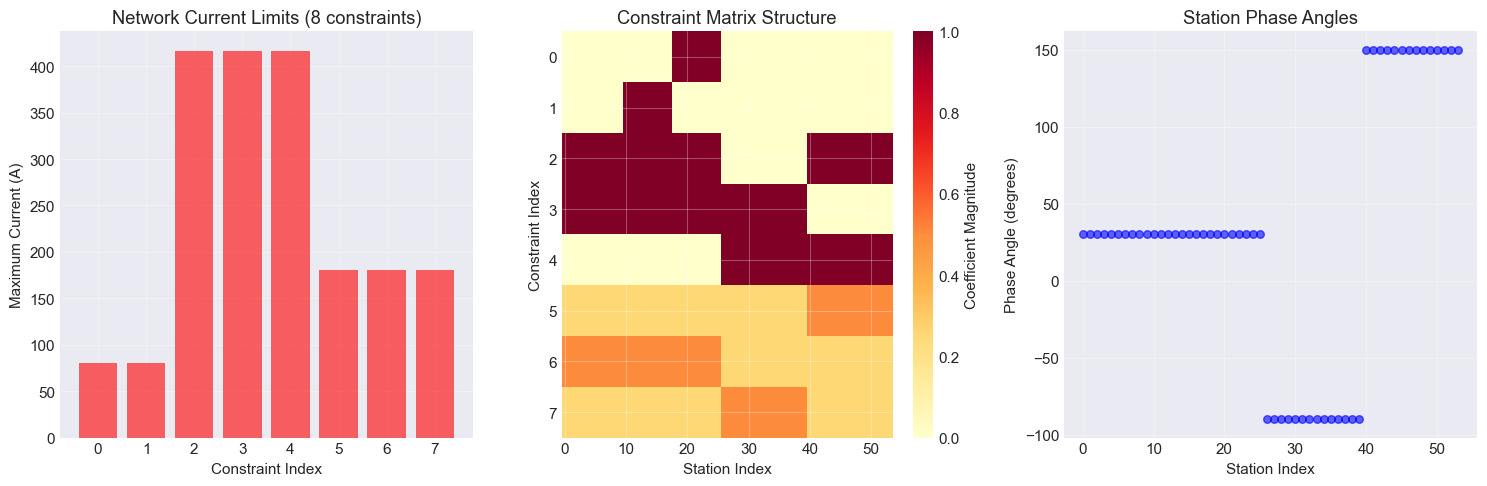

In [6]:
# Load the Caltech charging network
# We instantiate the Caltech network via `site_str_to_site('caltech')`, 
# which returns an ACN-Sim `ChargingNetwork`.
cn = site_str_to_site('caltech')

# Visualize network topology and constraints
# Constraint limits (`cn.magnitudes`): 
#   Each entry is a maximum allowable current (Amps) for a network constraint (e.g., feeder, transformer). These are the caps the env must respect.
# Constraint matrix (`cn.constraint_matrix`): 
#   A linear map that aggregates per-station currents into each network constraint. Its absolute values highlight how strongly each station contributes to each constraint.
# Station phase angles (`cn._phase_angles`): 
#   Electrical phases (degrees) for each station. The environment uses these to form complex phasors so aggregate current is computed as a magnitude, not a plain sum.

idx_constraints = np.arange(len(cn.magnitudes))
idx_angles = np.arange(len(cn._phase_angles))

quick_plot({
    'layout': '1x3', 'size': (15, 5), 'tight': True,
    'plots': [
        { 'type': 'bar', 'x': 'idx_constraints', 'y': 'limits', 'color': 'red', 'alpha': 0.6,
          'title': f'Network Current Limits ({len(cn.magnitudes)} constraints)', 'xlabel': 'Constraint Index', 'ylabel': 'Maximum Current (A)' },
        { 'type': 'heatmap', 'data': 'C_abs', 'cmap': 'YlOrRd', 'clabel': 'Coefficient Magnitude',
          'title': 'Constraint Matrix Structure', 'xlabel': 'Station Index', 'ylabel': 'Constraint Index' },
        { 'type': 'scatter', 'x': 'idx_angles', 'y': 'angles', 'alpha': 0.6, 'size': 30,
          'title': 'Station Phase Angles', 'xlabel': 'Station Index', 'ylabel': 'Phase Angle (degrees)' },
    ]
}, {
    'idx_constraints': idx_constraints,
    'limits': cn.magnitudes,
    'C_abs': np.abs(cn.constraint_matrix),
    'idx_angles': idx_angles,
    'angles': cn._phase_angles,
})

show("section: Network Statistics")
show_metrics({
    'Total stations': env.num_stations,
    'Constraint count': len(cn.magnitudes),
    'Average limit (A)': f"{np.mean(cn.magnitudes):.1f}",
    'Tightest constraint (A)': f"{np.min(cn.magnitudes):.1f}",
})

### CVXPY magnitude-constraint mini-demo

Below we call the exact same constraint used by the environment, `envs/evcharging/env.py::magnitude_constraint`, inside CVXPY. We solve the minimal feasibility problem

$$\min_{\,\text{traj}\ge0}\ \mathbf{1}^\top\text{traj}\quad\text{s.t.}\quad \big|\tilde A\,\text{traj}\big|\cdot 32\ \le\ \text{magnitudes}.$$

Because the objective minimizes the sum, the optimal solution is the all-zero action (any tiny nonzeros are numerical noise). In contrast, the environment’s projection finds the nearest feasible action to the policy’s proposal.

In [7]:
if CVXPY_AVAILABLE:
    import cvxpy as cp
    from envs.evcharging.env import magnitude_constraint

    num = env.num_stations
    traj = cp.Variable((num, 1), nonneg=True)   # single-step action
    constr = [magnitude_constraint(traj, env.cn)]
    prob = cp.Problem(cp.Minimize(cp.sum(traj)), constr)
    try:
        status = solve_cvx_with_fallback(prob, verbose=True)
        show("section: CVXPY Constraint Solver")
        show_metrics({
            'Status': status,
            'Feasible action (first 5)': traj.value[:5, 0].tolist() if traj.value is not None else 'N/A',
        })
    except RuntimeError as e:
        show("warning: CVXPY solver failed: {error}", error=str(e))
else:
    show("warning: CVXPY not installed, skipping constraint solver demo")


#### Interpretation
- If Status is “optimal,” the constraint set is non-empty and the solver succeeded.
- The reported feasible action is ~0 because we minimized $\sum\text{traj}$.
- This is the same $\tilde A$ and `magnitudes` shown in the visualization. To see non-zero safe capacity, change the objective to maximize $\sum\text{traj}$ with bounds $0\le\text{traj}\le1$.

### Interactive Constraint Violation Demo

Why you might see no violations: at many timesteps only a few stations are active, so even large normalized actions don’t overload the smallest constraint. To make the mechanism obvious, the demo can either:

- Seek a real timestep with nonzero demand and stress only active stations, or
- Force a synthetic stress on the tightest constraint by energizing its top-k loading stations (ignores demand), then project to the nearest feasible action using the same constraint as above.


In [8]:
def constraint_violation_demo():
    """Interactive demonstration of constraint projection with options to force a violation."""
    
    def test_action_level(aggression=0.5, show_projection=True, max_seek_steps=200, force_violation=False, k_loaders=8):
        # Reset and seek a timestep that has any nonzero demand
        obs, _ = env.reset(seed=42)
        step = 0
        while step < max_seek_steps and not np.any(obs['demands'] > 0):
            obs, _, done, _, _ = env.step(np.zeros(env.num_stations, dtype=np.float32))
            step += 1
            if done:
                obs, _ = env.reset()
        
        # Create a stressing requested action
        if force_violation:
            # Target the tightest constraint, turn on its top-k contributors
            C = cn.constraint_matrix
            tight_idx = int(np.argmin(cn.magnitudes))
            top = np.argsort(np.abs(C[tight_idx]))[-int(max(1, k_loaders)) :]
            test_action = np.zeros(env.num_stations, dtype=float)
            test_action[top] = (0.5 + aggression)  # allow >1.0 to clearly stress before projection
        else:
            base_action = np.where(obs['demands'] > 0, 1.0, 0.0)
            test_action = base_action * (0.5 + aggression)
        
        # Calculate aggregate currents
        phase_factor = np.exp(1j * np.deg2rad(cn._phase_angles))
        A_tilde = cn.constraint_matrix * phase_factor[None, :]
        agg_current = np.abs(A_tilde @ test_action) * env.ACTION_SCALE_FACTOR
        
        # Get projected action if enabled (compute true projection with CVXPY if available)
        if show_projection:
            projected = np.clip(test_action, 0.0, 1.0)
            try:
                if CVXPY_AVAILABLE:
                    import cvxpy as cp
                    x = cp.Variable(env.num_stations, nonneg=True)
                    # Demand-implied cap like env: cap = min(1, demand / (A_per_step * 32))
                    cap = np.minimum(1.0, np.divide(obs['demands'], env.A_PERS_TO_KWH * env.ACTION_SCALE_FACTOR, out=np.ones_like(obs['demands']), where=(env.A_PERS_TO_KWH*env.ACTION_SCALE_FACTOR)>0))
                    constr = [ x <= cap, magnitude_constraint(x, cn) ]
                    prob = cp.Problem(cp.Minimize(cp.norm(x - test_action, 2)), constr)
                    solve_cvx_with_fallback(prob, verbose=False)
                    if x.value is not None:
                        projected = np.asarray(x.value).reshape(-1)
            except Exception as _e:
                pass
            agg_projected = np.abs(A_tilde @ projected) * env.ACTION_SCALE_FACTOR
        else:
            projected = test_action
            agg_projected = agg_current
        
        # Find violations
        violations = agg_current > cn.magnitudes
        violation_indices = np.where(violations)[0]
        violation_values = agg_current[violations] if any(violations) else []
        
        # Prepare data
        x_stations = np.arange(env.num_stations)
        x_constraints = np.arange(len(cn.magnitudes))
        
        # Use quick_plot
        quick_plot({
            'layout': '1x2',
            'size': (14, 5),
            'plots': [
                {'type': 'bar_multi',
                 'bars': [
                     {'x': x_stations, 'y': test_action, 'offset': -0.175, 'width': 0.35,
                      'label': 'Requested', 'alpha': 0.7, 'color': 'orange'},
                     {'x': x_stations, 'y': projected, 'offset': 0.175, 'width': 0.35,
                      'label': 'Projected', 'alpha': 0.7, 'color': 'green'}
                 ],
                 'title': f'Action Projection (Aggression: {aggression:.1f}, step={step})',
                 'xlabel': 'Station ID', 'ylabel': 'Normalized Action',
                 'legend': True},
                {'type': 'bar_multi',
                 'bars': [
                     {'x': x_constraints, 'y': cn.magnitudes, 'offset': 0, 'width': 0.8,
                      'alpha': 0.3, 'label': 'Limits', 'color': 'red'},
                     {'x': x_constraints, 'y': agg_current, 'offset': -0.2, 'width': 0.4,
                      'alpha': 0.7, 'label': 'Requested', 'color': 'orange'},
                     {'x': x_constraints, 'y': agg_projected, 'offset': 0.2, 'width': 0.4,
                      'alpha': 0.7, 'label': 'Projected', 'color': 'green'}
                 ],
                 'overlay_markers': {'x': violation_indices, 'y': violation_values,
                                    'color': 'red', 'marker': 'x', 'size': 100,
                                    'linewidth': 3, 'label': 'Violations'} if any(violations) else None,
                 'title': 'Aggregate Current vs Limits',
                 'xlabel': 'Constraint Index', 'ylabel': 'Current (A)',
                 'legend': True}
            ]
        })
        
        # Report statistics using show
        total_violation = np.sum(np.maximum(0, agg_current - cn.magnitudes))
        total_saved = np.sum(np.maximum(0, agg_current - agg_projected))
        
        show("section: Violation Statistics")
        show_metrics({
            'Total violation (before)': f"{total_violation:.1f} A",
            'Current saved by projection': f"{total_saved:.1f} A",
            'Constraints violated': f"{np.sum(violations)} / {len(cn.magnitudes)}"
        })
    
    # Inline instructions (compact) shown above the interactive widgets/plots
    show("section: How to use this demo")
    show("list: Parameters",
         items=[
             "aggression: scales requested action; >1 over-requests before projection",
             "show_projection: when on, computes nearest feasible action via magnitude constraint + demand caps",
             "max_seek_steps: advance after reset to find a timestep with nonzero demand",
             "force_violation: ignore demand; energize top-k contributors to the tightest constraint",
             "k_loaders: number of stations to energize when force_violation is enabled",
         ])

    interact(test_action_level, 
             aggression=(0.0, 2.0, 0.1),
             show_projection=True,
             max_seek_steps=(0, 500, 10),
             force_violation=False,
             k_loaders=(1, 32, 1))

constraint_violation_demo()

interactive(children=(FloatSlider(value=0.5, description='aggression', max=2.0), Checkbox(value=True, descript…

## Section 3: Reward Engineering

We use a simple additive reward that values delivered energy (revenue) while accounting for carbon costs. Safety is tracked but not added to the reward in this tutorial (we visualize it separately). At each timestep $t$, the reward combines three components:

$$
r_t \;=\; \underbrace{\alpha\,\sum_j I_{t,j}}_{\text{profit}}\;\; -\;\; \underbrace{\beta\,\sum_j I_{t,j}\,\text{MOER}_t}_{\text{carbon cost}}\,,\quad\text{with } I_{t,j}\text{ in Amps.}
$$

Here $\alpha =$ `EVChargingEnv.PROFIT_FACTOR` and $\beta =$ `EVChargingEnv.CARBON_COST_FACTOR`. The per-episode return is $R=\sum_t r_t$. Network constraint excess is tracked as an auxiliary series (not subtracted in $r_t$ here):

$$
\text{excess}_t\;=\;\max\bigl\{0,\;\|\tilde A\,a_t\|\cdot 32\; -\; \text{magnitudes}\bigr\}_1\,.
$$

We also report a true satisfaction metric computed from the simulator:

$$
\text{satisfaction}\;=\;\frac{\text{delivered (kWh)}}{\max(\text{requested (kWh)},\,\varepsilon)}\,.
$$

Notes:
- Profit and carbon use the actual charging current delivered each step; units are normalized to dollars via environment constants.
- Constraint excess is still computed every step and displayed, but not penalized in $r_t$ in this tutorial.
- True satisfaction comes from simulator logs and avoids the pitfalls of snapshot-based proxies.


### Reward Component Analysis


In [9]:
def reward_component_analysis():
    """Reward analysis using standardized utilities"""
    
    def adaptive_policy(obs):
        moer = obs['prev_moer'][0]
        if moer < 0.3:
            return np.where(obs['demands'] > 0, 1.0, 0.0)
        elif moer < 0.7:
            return np.where(obs['demands'] > 10, 0.7, 0.0)
        else:
            return np.where(obs['est_departures'] < 20, 0.3, 0.0)
    
    # Evaluate with comprehensive tracking
    mean_ret, std_ret, mean_cost, metrics = evaluate_policy(
        policy_fn=adaptive_policy,
        make_env_fn=lambda **kw: EVChargingEnv(gen, project_action_in_env=True, **kw),
        episodes=1,
        horizon=288,
        track_metrics=['components', 'satisfaction', 'actions', 'trajectory'],
        verbose=True
    )
    
    # Get behavior fingerprint
    fingerprint = policy_behavior_fingerprint(
        policy_fn=adaptive_policy,
        env_fn=lambda: EVChargingEnv(gen, project_action_in_env=True),
        n_samples=100
    )
    
    # Formatted summary display
    show("header: Reward Analysis Summary")
    show_metrics({
        'Total return': f'${mean_ret:.2f}',
        'Profit': f'${metrics.get("profit_mean", 0):.2f}',
        'Carbon cost': f'${metrics.get("carbon_cost_mean", 0):.2f}',
        'Violations': f'${mean_cost:.2f}',
        'True satisfaction': f'{metrics.get("true_satisfaction_mean", 0)*100:.1f}%',
        'Delivered energy (kWh)': f'{metrics.get("delivered_kwh_mean", 0):.2f}',
        'Requested energy (kWh)': f'{metrics.get("requested_kwh_mean", 0):.2f}',
    })
    show("section: Behavior Fingerprint")
    show_metrics(fingerprint)
    
    # Save for cross-tutorial comparison
    save_evaluation_results(
        tag="tutorial01_adaptive_policy",
        policy_name="MOER-aware Adaptive",
        mean_return=mean_ret,
        std_return=std_ret,
        mean_cost=mean_cost,
        metrics=metrics,
        env_config={'site': 'caltech', 'horizon': 288},
        notes="2-hour reward component analysis"
    )

reward_component_analysis()

### Configurable Multi-Objective Reward

Experiment with reward weights interactively and see how the scalar objective changes over time. We recompute a weighted objective from the per-step reward components returned by the environment via `info['reward_breakdown']` using the shared utilities.

#### Why this matters

When we have multiple objectives (e.g., profit, carbon, and violations), we usually aggregate them into a single score so a policy can be compared or optimized. A common approach is a weighted sum at each step:

$J_t = w_p\, r^{profit}_t \; - \; w_c\, r^{carbon}_t \; - \; w_v\, r^{viol}_t.$

Changing the weights changes what “good” means. This cell helps you build intuition for that trade-off: you can adjust $(w_p, w_c, w_v)$ and see, on the same underlying trajectory, how the scalarized score $J_t$ moves relative to its components.

#### How to read the chart

- The left axis shows the per-step components $r^{profit}_t, r^{carbon}_t, r^{viol}_t$.
- The right axis shows the weighted scalar $J_t$ computed with your current weights.
- Move the sliders to see how emphasizing one objective (e.g., larger $w_c$) pulls the overall score up or down where that component is large.

*Notes:* We keep the time series fixed (per horizon and seed) so weight changes only affect the aggregation, not the underlying data. We also start from an “active” period and display per-step values to make trends visible.

In [10]:
import numpy as np
from ipywidgets import interact, FloatSlider, IntSlider

from tutorials.utils import create_ev_env, show, show_metrics, standardize_trajectory_costs, seek_to_active, quick_plot

_reward_demo_cache = {'horizon': None, 'seed': None, 'profit': None, 'carbon': None, 'viol': None}

def configurable_reward_demo(w_profit=1.0, w_carbon=1.0, w_violation=1.0, horizon=96, seed=0):
    """Interactive demo: recompute a scalarized objective J_t = w_p*profit - w_c*carbon - w_v*violation."""

    # The baseline policy is a simple greedy rule by demand (projected by the environment as needed).
    def baseline_policy(obs):
        if isinstance(obs, dict) and 'demands' in obs:
            return np.where(obs['demands'] > 0, 0.8, 0.0)
        # Fallback if observation is flattened
        return np.zeros(1, dtype=np.float32)

    # Cache a single rollout per horizon so weight changes don't resample the env
    global _reward_demo_cache
    if (
        _reward_demo_cache.get('horizon') != int(horizon)
        or _reward_demo_cache.get('seed') != int(seed)
        or _reward_demo_cache.get('profit') is None
    ):
        env = create_ev_env(flatten=False, dense_mode=TUTORIAL_DENSE, density_multiplier=EVAL_CFG.density_multiplier)
        try:
            obs, info = env.reset(seed=int(seed))
            # Before collecting data, we “seek to active”:
            #   - Find the first timestep where total positive demand is nonzero: $\sum_i \max(d_{t,i}, 0) > 0$.
            #   - Optionally ensure the total demand changes within a short lookahead to avoid flat segments: $\big|\sum_i \max(d_{t+k,i}, 0) - \sum_i \max(d_{t,i}, 0)\big| > \varepsilon$.
            obs, info, _ = seek_to_active(env, key='demands', max_seek=200, ensure_change=True, lookahead=20, reset_seed=int(seed))
            profit_list, carbon_list, viol_list = [], [], []
            t = 0
            done = False
            while t < int(horizon) and not done:
                action = baseline_policy(obs)
                obs_next, r, term, trunc, info = env.step(action)
                rb = info.get('reward_breakdown', {}) if isinstance(info, dict) else {}
                profit_list.append(float(rb.get('profit', 0.0)))
                carbon_list.append(float(rb.get('carbon_cost', 0.0)))
                viol_list.append(float(rb.get('excess_charge', 0.0)))
                obs = obs_next
                done = bool(term) or bool(trunc)
                t += 1
            traj = {
                'profit': np.array(profit_list, dtype=float),
                'carbon_cost': np.array(carbon_list, dtype=float),
                'excess_charge': np.array(viol_list, dtype=float),
            }
            traj = standardize_trajectory_costs(traj)
        finally:
            try:
                env.close()
            except Exception:
                pass
        
        # To keep the trajectory fixed while you vary weights, the cell caches a single rollout per (horizon, seed). 
        # Changing $w_p, w_c, w_v$ recomputes $J_t$ without resampling. Changing the seed or horizon triggers a new rollout.
        _reward_demo_cache = {
            'horizon': int(horizon),
            'seed': int(seed),
            'profit': traj['profit'],
            'carbon': traj['carbon_cost'],
            'viol': traj['excess_charge'],
        }

    profit = np.asarray(_reward_demo_cache['profit'], dtype=float)
    carbon = np.asarray(_reward_demo_cache['carbon'], dtype=float)
    viol = np.asarray(_reward_demo_cache['viol'], dtype=float)
    T = min(len(profit), len(carbon), len(viol))
    if T == 0:
        show("warning: No trajectory available to compute weighted reward. Try increasing horizon or seeking to an active timestep.")
    else:
        profit = profit[:T]
        carbon = carbon[:T]
        viol = viol[:T]
        J_t = w_profit * profit - w_carbon * carbon - w_violation * viol

        # Summary metrics
        show("section: Configurable Reward Summary")
        show_metrics({
            'Horizon (steps)': int(T),
            'Sum(J)': float(np.sum(J_t)),
            'Profit sum': float(np.sum(profit)),
            'Carbon cost sum': float(np.sum(carbon)),
            'Violation cost sum': float(np.sum(viol)),
        })
        # Visualization: dual y-axis via quick_plot (components on left, J_t on right)
        t = np.arange(T)
        quick_plot({
            'type': 'line',
            'x': t,
            'y': {
                'profit': profit,
                'carbon_cost': carbon,
                'excess_charge': viol,
            },
            'legend': True,
            'xlabel': 'timestep',
            'ylabel': 'components',
            'size': (12, 5),
            'grid': True,
            'twin_y': {
                'type': 'line',
                'x': t,
                'y': J_t,
                'label': 'J_t',
                'color': 'blue',
                'ylabel': 'weighted objective (J_t)',
                'legend': True,
                'legend_loc': 'upper right',
            },
        })

w = interact(
    configurable_reward_demo,
    w_profit=FloatSlider(value=1.0, min=0.0, max=2.0, step=0.05, description='w_profit'),
    w_carbon=FloatSlider(value=1.0, min=0.0, max=2.0, step=0.05, description='w_carbon'),
    w_violation=FloatSlider(value=1.0, min=0.0, max=2.0, step=0.05, description='w_violation'),
    horizon=IntSlider(value=96, min=24, max=288, step=12, description='horizon'),
    seed=IntSlider(value=0, min=0, max=9999, step=1, description='seed')
)

interactive(children=(FloatSlider(value=1.0, description='w_profit', max=2.0, step=0.05), FloatSlider(value=1.…

### Action Distribution Analysis
- We control an EV charging network with `N` stations over timesteps `t = 0, 1, ..., T-1`.
- At each `t`, the policy outputs an action vector
  $$
  \mathbf{a}_t \in [0,1]^N, \quad \mathbf{a}_t = (a_{t,1}, \dots, a_{t,N}),
  $$
  where each component is a normalized pilot signal (0 = no charge, 1 = max).

- We analyze “saturation” using two thresholds
  $$
  \tau_{\mathrm{L}} \in [0,1], \quad \tau_{\mathrm{H}} \in [0,1], \quad \text{with } \tau_{\mathrm{L}} \ll \tau_{\mathrm{H}},
  $$
  typically $\tau_{\mathrm{L}} = 0.001$ and $\tau_{\mathrm{H}} = 0.999$.

- We focus on “active” periods where demand is nonzero. Operationally, we seek a start index $t_0$ with nontrivial demand and then roll out for $H$ steps. Note: the seek horizon `max_seek` bounds only the search phase, not the subsequent rollout horizon `H`.


We flatten all actions across time and stations:
$$
\mathcal{A} \;=\; \{\, a_{t,i} \mid t=0,\dots,T-1,\; i=1,\dots,N \,\}.
$$

From $\mathcal{A}$ we compute:
- Mean and variance: $\mu = \mathbb{E}[a]$, $\sigma^2 = \mathrm{Var}(a)$,
- Quantiles (e.g., median, IQR),
- Saturation rates:
  $$
  s_{\mathrm{low}} \;=\; \frac{1}{TN}\sum_{t=0}^{T-1}\sum_{i=1}^{N}\mathbf{1}\{a_{t,i} \le \tau_{\mathrm{L}}\}, \quad
  s_{\mathrm{high}} \;=\; \frac{1}{TN}\sum_{t=0}^{T-1}\sum_{i=1}^{N}\mathbf{1}\{a_{t,i} \ge \tau_{\mathrm{H}}\}.
  $$

**Interpretation:**
- Large $s_{\mathrm{low}}$ implies the policy often outputs (near) zero. In EV charging, that means “turn off” decisions are frequent.
- Large $s_{\mathrm{high}}$ implies frequent max charging signals.
- The histogram/KDE visualize the empirical distribution of $\mathcal{A}$; the saturation panel summarizes how often the policy is at the extremes.


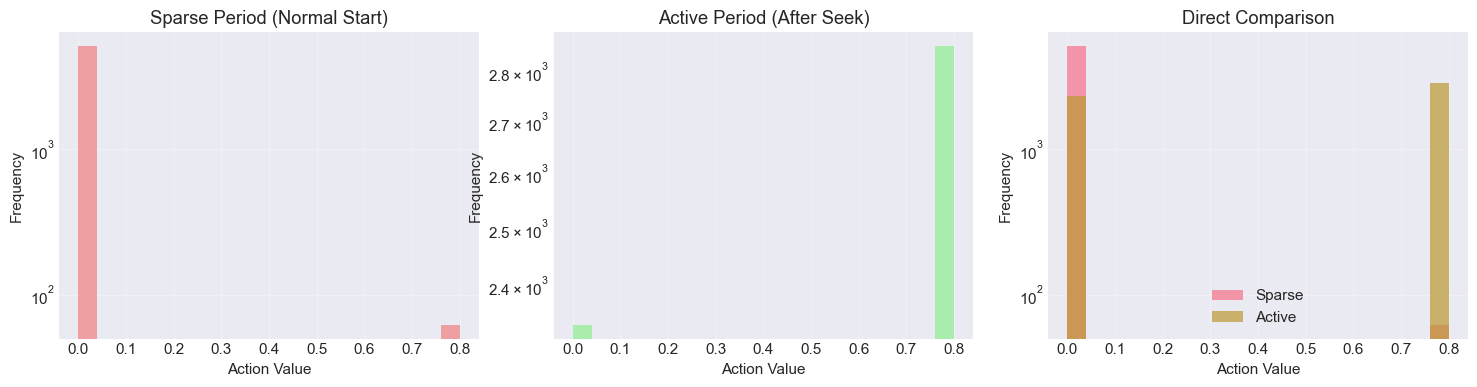

In [11]:
# Contrast action distributions between sparse vs active periods
def action_distribution_contrast():
    """Compare action distributions: sparse (normal start) vs active (after seek)."""
    from tutorials.utils import wrap_policy, extract_from_obs, evaluate_policy, create_ev_env, seek_to_active, save_evaluation_results

    # Greedy-by-demand baseline, using safe extraction
    greedy_policy = wrap_policy(lambda obs: np.where(extract_from_obs(obs, 'demands') > 0, 0.8, 0.0))

    # 1) Sparse period (normal reset)
    mean_ret_s, std_ret_s, mean_cost_s, metrics_sparse = evaluate_policy(
        policy_fn=greedy_policy,
        make_env_fn=lambda **kw: create_ev_env(flatten=False, dense_mode=TUTORIAL_DENSE, density_multiplier=EVAL_CFG.density_multiplier, **kw),
        episodes=1,
        horizon=96,
        track_metrics=['actions'],
        verbose=False,
    )
    sparse_actions = np.asarray(metrics_sparse['actions_per_episode'][0]).reshape(-1)

    # 2) Active period (after seek)
    class ActiveStartWrapper:
        def __init__(self, base_env):
            self.env = base_env
        def reset(self, seed=None):
            obs, info = self.env.reset(seed=seed)
            obs, info, _ = seek_to_active(self.env, key='demands', max_seek=400, ensure_change=True)
            return obs, info
        def step(self, action):
            return self.env.step(action)
        def __getattr__(self, name):
            return getattr(self.env, name)

    def make_active_env(**kw):
        # Forward any noise kwargs from evaluate_policy into the base env
        base = create_ev_env(flatten=False, dense_mode=TUTORIAL_DENSE, density_multiplier=EVAL_CFG.density_multiplier, **kw)
        return ActiveStartWrapper(base)

    mean_ret_a, std_ret_a, mean_cost_a, metrics_active = evaluate_policy(
        policy_fn=greedy_policy,
        make_env_fn=make_active_env,
        episodes=1,
        horizon=96,
        track_metrics=['actions'],
        verbose=False,
    )
    active_actions = np.asarray(metrics_active['actions_per_episode'][0]).reshape(-1)

    # Plot side-by-side histograms and a combined comparison
    quick_plot({
        'layout': '1x3', 'size': (15, 4), 'tight': True,
        'plots': [
            { 'type': 'hist', 'data': sparse_actions, 'bins': 20, 'color': 'lightcoral', 'alpha': 0.7,
              'title': 'Sparse Period (Normal Start)', 'xlabel': 'Action Value', 'ylabel': 'Frequency' },
            { 'type': 'hist', 'data': active_actions, 'bins': 20, 'color': 'lightgreen', 'alpha': 0.7,
              'title': 'Active Period (After Seek)', 'xlabel': 'Action Value', 'ylabel': 'Frequency' },
            { 'type': 'hist', 'data': {'Sparse': sparse_actions, 'Active': active_actions}, 'bins': 20, 'alpha': 0.7,
              'title': 'Direct Comparison', 'xlabel': 'Action Value', 'ylabel': 'Frequency', 'legend': True },
        ]
    })
    # Log-scale y for sparsity visualization
    fig = plt.gcf()
    for ax in fig.axes:
        ax.set_yscale('log')
    plt.show()

    # Summary metrics
    show("section: Action Distribution Contrast — Summary")
    show_metrics({
        'Sparse — % zeros': f"{100.0 * float(np.mean(sparse_actions < 1e-3)):.1f}%",
        'Sparse — mean action': float(np.mean(sparse_actions)),
        'Active — % zeros': f"{100.0 * float(np.mean(active_actions < 1e-3)):.1f}%",
        'Active — mean action': float(np.mean(active_actions)),
        'Activity increase (mean)': f"{(float(np.mean(active_actions)) / max(float(np.mean(sparse_actions)), 1e-6)):.1f}x",
    })

    # Save lightweight summary for reuse
    _ = save_evaluation_results(
        tag="action_distribution_contrast",
        policy_name="Greedy",
        mean_return=float(mean_ret_a),
        std_return=float(std_ret_a),
        mean_cost=float(mean_cost_a),
        metrics={
            'sparse_mean_action': float(np.mean(sparse_actions)),
            'active_mean_action': float(np.mean(active_actions)),
            'sparse_pct_zeros': float(np.mean(sparse_actions < 1e-3)),
            'active_pct_zeros': float(np.mean(active_actions < 1e-3)),
        },
        env_config={'horizon': 96},
        notes='Contrast sparse vs active periods for greedy policy',
    )

action_distribution_contrast()

First analyzing with regular environment to establish baseline sparsity — most timesteps have no active charging sessions
This mirrors typical real-world utilization where demand is intermittent; we contrast it with a denser synthetic scenario next


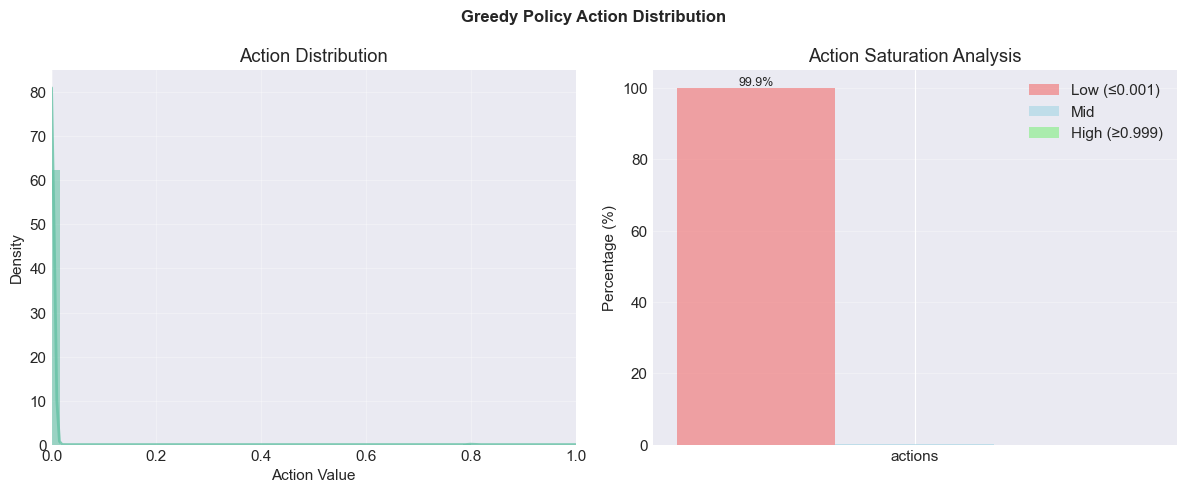

Now analyzing the same policy with dense environment (3x event density)


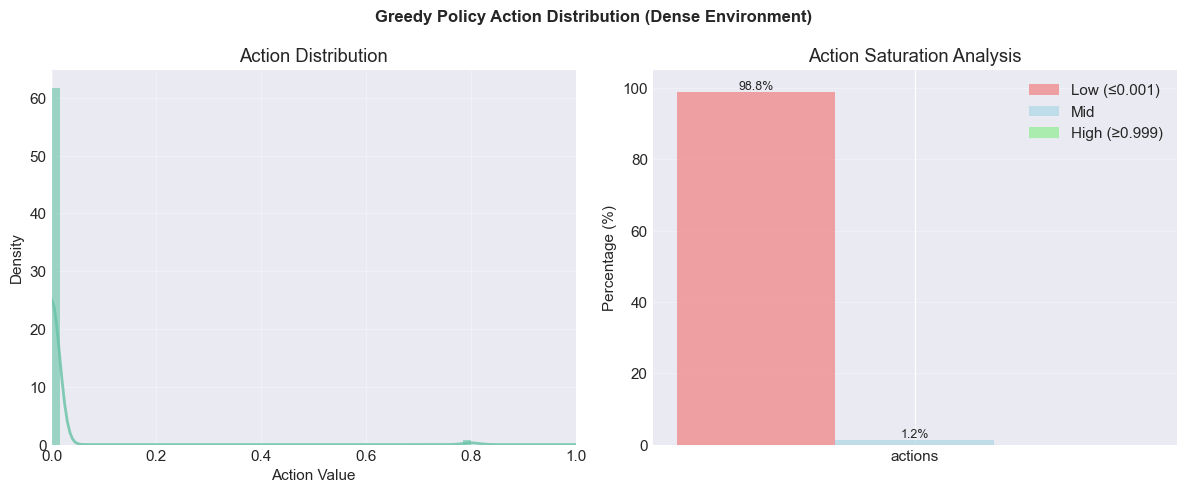

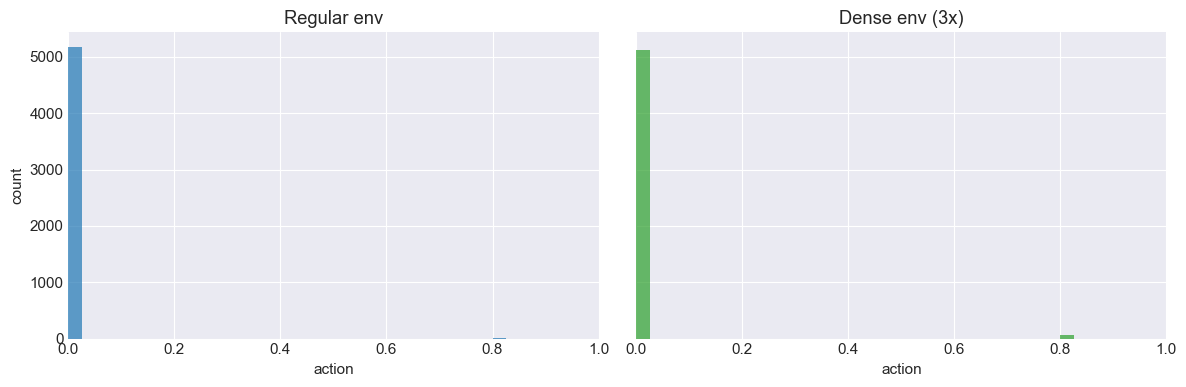

In [12]:
# Simpler and returns stats for further analysis
_, _, _, metrics = evaluate_policy(
    policy_fn=wrap_policy(lambda obs: np.where(obs['demands'] > 0, 0.8, 0.0)),
    make_env_fn=lambda **kw: EVChargingEnv(gen, project_action_in_env=True, **kw),
    episodes=1,
    horizon=96,
    track_metrics=['actions'],
)

# Plot without the center text panel; print a compact summary below like other utils
show("section: Baseline Action Distribution (Regular Environment)")
show("info: First analyzing with regular environment to establish baseline sparsity — most timesteps have no active charging sessions")
show("info: This mirrors typical real-world utilization where demand is intermittent; we contrast it with a denser synthetic scenario next")
stats = plot_action_distribution(
    metrics['actions_per_episode'][0],
    title='Greedy Policy Action Distribution',
    show_stats=True,           # prints summary via show/show_metrics
    show_saturation=True,
    return_stats=True
)

show("section: Key saturation metrics")
show_metrics({
    'Low saturation (≤0.001)': f"{stats.get('saturation_low', 0.0)*100:.1f}%",
    'High saturation (≥0.999)': f"{stats.get('saturation_high', 0.0)*100:.1f}%",
})

# Dense environment contrast (3x event density)
show("section: Dense Environment Action Distribution")
show("info: Now analyzing the same policy with dense environment (3x event density)")

_, _, _, metrics_dense = evaluate_policy(
    policy_fn=wrap_policy(lambda obs: np.where(extract_from_obs(obs, 'demands') > 0, 0.8, 0.0)),
    make_env_fn=lambda **kw: create_ev_env(flatten=False, dense_mode=True, density_multiplier=EVAL_CFG.density_multiplier, **kw),
    episodes=1,
    horizon=96,
    track_metrics=['actions'],
)

stats_dense = plot_action_distribution(
    metrics_dense['actions_per_episode'][0],
    title='Greedy Policy Action Distribution (Dense Environment)',
    show_stats=True,
    show_saturation=True,
    return_stats=True
)

show("section: Impact of Environment Density on Action Distribution")
show_metrics({
    'Regular Environment': {
        'Low saturation (≤0.001)': f"{stats.get('saturation_low', 0.0)*100:.1f}%",
        'Mean action': stats.get('mean', 0.0),
        'Active actions (>0.001)': f"{(1-stats.get('saturation_low', 0.0))*100:.1f}%"
    },
    'Dense Environment': {
        'Low saturation (≤0.001)': f"{stats_dense.get('saturation_low', 0.0)*100:.1f}%",
        'Mean action': stats_dense.get('mean', 0.0),
        'Active actions (>0.001)': f"{(1-stats_dense.get('saturation_low', 0.0))*100:.1f}%"
    },
    'Density Impact': {
        'Activity increase': f"{stats_dense.get('mean', 0.0)/max(stats.get('mean', 0.0), 1e-9):.1f}x",
        'Sparsity reduction': f"{(stats.get('saturation_low', 0.0) - stats_dense.get('saturation_low', 0.0))*100:.1f} pp"
    }
})

# Side-by-side histograms for direct comparison
show("section: Side-by-Side Distribution Comparison")
a_reg = np.asarray(metrics['actions_per_episode'][0]).ravel()
a_den = np.asarray(metrics_dense['actions_per_episode'][0]).ravel()
bins = np.linspace(0, 1, 41)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].hist(a_reg, bins=bins, color='tab:blue', alpha=0.7)
axes[0].set_title("Regular env")
axes[0].set_xlabel("action")
axes[0].set_ylabel("count")
axes[0].set_xlim(0, 1)

axes[1].hist(a_den, bins=bins, color='tab:green', alpha=0.7)
axes[1].set_title("Dense env (3x)")
axes[1].set_xlabel("action")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## Section 4: Evaluating EV Charging Strategies

We compare five interpretable baseline strategies to understand the performance landscape.

### Strategy Definitions
Each strategy is a rule mapping the observation to an action vector $a_t = (a_{1,t},\dots,a_{N,t})$.

**Aggressive** (*Maximize throughput*): Always max-charge where there’s demand:
$$a_{i,t} = \mathbb{1}[d_{i,t} > 0]$$

**Safety-First** (*Avoid constraint violations*): Conservative charging to reduce violations:
$$a_{i,t} = 0.5 \cdot \mathbb{1}[d_{i,t} > 0]$$

**Eco-Friendly** (*Minimize carbon footprint*): Charge fully only when carbon intensity (MOER) is low; otherwise trickle for urgent EVs:
$$a_{i,t} = \begin{cases}
\mathbb{1}[d_{i,t} > 0] & \text{if MOER}_t < 0.3 \\
0.3 \cdot \mathbb{1}[\tau_{i,t} < 10] & \text{otherwise}
\end{cases}$$

**Balanced** (*Balance all objectives*): Blend urgency and “eco” factor $(1-\mathrm{MOER}_t)$:
$$a_{i,t} = \min\{1, 1.5 \cdot u_{i,t} \cdot (1-\text{MOER}_t)\} \cdot \mathbb{1}[d_{i,t} > 0]$$
where $u_{i,t} = \mathbb{1}[\tau_{i,t} < 20]$

**Profit-Max** (*Prioritize high-value sessions*): Prioritize high-demand EVs:
$$a_{i,t} = \begin{cases}
1 & \text{if } d_{i,t} > \text{median}(\{d_{j,t} : d_{j,t} > 0\}) \\
0.3 & \text{if } 0 < d_{i,t} \leq \text{median} \\
0 & \text{if } d_{i,t} = 0
\end{cases}$$

### Evaluation protocol (apples-to-apples)

- Common start state: same seed and same post-reset “active” position using `seek_to_active`.
- Fixed horizon $T$ (e.g., 96 steps = 8 hours).
- For each strategy, run one rollout from that state and log time series.

We form cumulative versions (by summing per-step values):
- Cumulative score: $R_t \triangleq \sum_{\tau=0}^t r_\tau$
- Cumulative profit: $P_t \triangleq \sum_{\tau=0}^t p_\tau$
- Cumulative carbon: $C_t \triangleq \sum_{\tau=0}^t c_\tau$
- Cumulative violations: $V_t \triangleq \sum_{\tau=0}^t v_\tau$

If the breakdown fields are reported as cumulative counters in the env, we take robust per-step deltas by differencing:
- $x_t = X_t - X_{t-1}$ if $X_t \ge X_{t-1}$, else treat $x_t$ as per-step.

We also compute a satisfaction proxy:
- $S_t \triangleq \dfrac{\sum_{\tau=0}^t \Delta E_\tau}{\sum_{\tau=0}^t \sum_{i=1}^N d^+_{i,\tau}}\times 100\%$,
  where $d^+_{i,\tau}=\max\{0,d_{i,\tau}\}$.
- This is an intuitive, if approximate, measure of “portion of requested energy served.”



In [13]:
# Minimal, interpretable strategy comparison from a shared starting point

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from envs.evcharging import EVChargingEnv
from tutorials.utils import quick_plot, show, show_metrics

# 1) Strategy definitions as callables: action = fn(obs, env)
def make_strategy_fns():
    def aggressive(obs, env):
        d = np.asarray(obs['demands']).astype(float)
        return np.where(d > 0, 1.0, 0.0)

    def eco_friendly(obs, env):
        d = np.asarray(obs['demands']).astype(float)
        dep = np.asarray(obs['est_departures']).astype(float)
        moer = float(np.asarray(obs['prev_moer'])[0]) if 'prev_moer' in obs else 0.5
        if moer < 0.3:
            return np.where(d > 0, 1.0, 0.0)
        else:
            return np.where(dep < 10, 0.3, 0.0)

    def balanced(obs, env):
        d = np.asarray(obs['demands']).astype(float)
        dep = np.asarray(obs['est_departures']).astype(float)
        moer = float(np.asarray(obs['prev_moer'])[0]) if 'prev_moer' in obs else 0.5
        a = np.zeros(env.num_stations, dtype=float)
        for i in range(env.num_stations):
            if d[i] > 0:
                urgency = 1.0 if dep[i] < 20 else 0.5
                eco = 1.0 - moer
                a[i] = min(1.0, urgency * eco * 1.5)
        return a

    def profit_max(obs, env):
        d = np.asarray(obs['demands']).astype(float)
        if np.max(d) > 0:
            pos = d[d > 0]
            thresh = np.percentile(pos, 50) if pos.size else 0.0
            return np.where(d > thresh, 1.0, 0.3)
        return np.zeros(env.num_stations, dtype=float)

    def safety_first(obs, env):
        d = np.asarray(obs['demands']).astype(float)
        return np.where(d > 0, 0.5, 0.0)

    return {
        'balanced': balanced,
        'aggressive': aggressive,
        'eco_friendly': eco_friendly,
        'profit_max': profit_max,
        'safety_first': safety_first,
    }

# 2) Roll a single strategy from the same seeded, active start
def roll_strategy(gen, strategy_fn, *, seed=0, horizon=96):
    env = EVChargingEnv(gen, project_action_in_env=True)
    obs, _ = env.reset(seed=seed)

    # Seek to a period with actual demand to avoid flat runs
    try:
        if isinstance(obs, dict) and 'demands' in obs and np.all(np.asarray(obs['demands']) <= 0):
            obs, _, _ = seek_to_active(env, key='demands', max_seek=400, ensure_change=True, lookahead=20)
    except Exception:
        pass

    last_rb = {'profit': 0.0, 'carbon_cost': 0.0, 'excess_charge': 0.0}
    # Use simulator-based satisfaction: requested_total_kwh from episode EVs, accumulate delivered kWh from charging rates
    requested_total_kwh = float(np.sum([float(getattr(ev, 'requested_energy', 0.0)) for ev in env._evs]))
    cumulative_delivered = 0.0

    rec = {
        't': [], 'reward': [], 'score_cum': [],
        'profit_step': [], 'profit_cum': [],
        'carbon_step': [], 'carbon_cum': [],
        'viol_step': [], 'viol_cum': [],
        'satisfaction': [],
    }
    score = 0.0

    try:
        for t in range(int(horizon)):
            a = np.asarray(strategy_fn(obs, env)).reshape(-1).astype(float)
            obs_next, reward, term, trunc, info = env.step(a)

            # Update scores
            score += float(reward)

            # Delivered energy (kWh) from simulator charging rates; robust to new arrivals
            if getattr(env, "_simulator", None) is not None and getattr(env._simulator, "charging_rates", None) is not None and env.t > 0:
                delivered_kwh_step = float(np.sum(env._simulator.charging_rates[:, env.t - 1])) * env.A_PERS_TO_KWH
            else:
                delivered_kwh_step = 0.0
            cumulative_delivered += delivered_kwh_step

            # Components: robust to cumulative or step-wise reporting
            rb = info.get('reward_breakdown', {}) if isinstance(info, dict) else {}
            p_cur = float(rb.get('profit', 0.0))
            c_cur = float(rb.get('carbon_cost', 0.0))
            v_cur = float(rb.get('excess_charge', 0.0))
            def step_delta(cur, prev): return cur - prev if cur >= prev else cur

            p_step = step_delta(p_cur, last_rb['profit'])
            c_step = step_delta(c_cur, last_rb['carbon_cost'])
            v_step = step_delta(v_cur, last_rb['excess_charge'])

            last_rb.update({'profit': p_cur, 'carbon_cost': c_cur, 'excess_charge': v_cur})

            # Record
            rec['t'].append(t)
            rec['reward'].append(float(reward))
            rec['score_cum'].append(float(score))
            rec['profit_step'].append(p_step)
            rec['carbon_step'].append(c_step)
            rec['viol_step'].append(v_step)
            rec['profit_cum'].append(rec['profit_cum'][-1] + p_step if rec['profit_cum'] else p_step)
            rec['carbon_cum'].append(rec['carbon_cum'][-1] + c_step if rec['carbon_cum'] else c_step)
            rec['viol_cum'].append(rec['viol_cum'][-1] + v_step if rec['viol_cum'] else v_step)
            sat = 100.0 * (cumulative_delivered / max(requested_total_kwh, 1e-9))
            rec['satisfaction'].append(float(sat))

            obs = obs_next
            if bool(term) or bool(trunc):
                break
    finally:
        try:
            env.close()
        except Exception:
            pass

    return pd.DataFrame(rec)

# 3) Compare a set of strategies with compact, informative plots
def compare_strategies(gen, which=('balanced','aggressive','eco_friendly','safety_first'), *, seed=0, horizon=288):
    F = make_strategy_fns()
    chosen = [w for w in which if w in F]
    runs = {name: roll_strategy(gen, F[name], seed=seed, horizon=horizon) for name in chosen}

    # Build tidy frames for grouped lines
    def melt(df, y, name):
        return pd.DataFrame({'t': df['t'].to_numpy(), 'value': df[y].to_numpy(), 'strategy': name})

    df_score = pd.concat([melt(df, 'score_cum', k) for k, df in runs.items()], ignore_index=True)
    df_sat   = pd.concat([melt(df, 'satisfaction', k) for k, df in runs.items()], ignore_index=True)
    df_viol  = pd.concat([melt(df, 'viol_cum', k) for k, df in runs.items()], ignore_index=True)

    # End-of-run summary (one point per strategy)
    summary = []
    for name, df in runs.items():
        if len(df) == 0:
            summary.append({'strategy': name, 'score': 0.0, 'profit': 0.0, 'carbon': 0.0, 'violations': 0.0, 'satisfaction': 0.0})
            continue
        summary.append({
            'strategy': name,
            'score': float(df['score_cum'].iloc[-1]),
            'profit': float(df['profit_cum'].iloc[-1]),
            'carbon': float(df['carbon_cum'].iloc[-1]),
            'violations': float(df['viol_cum'].iloc[-1]),
            'satisfaction': float(df['satisfaction'].iloc[-1]),
        })
    df_summary = pd.DataFrame(summary).sort_values(by='score', ascending=False)

    # Profit vs Carbon points
    df_points = df_summary[['strategy','profit','carbon']].copy()

    # 2x2 compact dashboard
    quick_plot({
        'layout': '2x2', 'size': (12, 8), 'tight': True,
        'title': 'Strategy Comparison (same seeded start)',
        'plots': [
            # Score over time (grouped)
            { 'type': 'line', 'data': df_score, 'x': 't', 'y': 'value', 'group': 'strategy', 'legend': True,
              'title': 'Cumulative Score', 'xlabel': 'Timestep', 'ylabel': 'Score ($)' },

            # Satisfaction over time (grouped)
            { 'type': 'line', 'data': df_sat, 'x': 't', 'y': 'value', 'group': 'strategy', 'legend': True,
              'title': 'Satisfaction', 'xlabel': 'Timestep', 'ylabel': 'Satisfaction (%)' },

            # Profit vs Carbon (one marker per strategy)
            { 'type': 'scatter', 'data': df_points, 'x': 'profit', 'y': 'carbon', 'hue': 'strategy',
              'title': 'Profit vs Carbon (end of run)', 'xlabel': 'Profit ($)', 'ylabel': 'Carbon Cost ($)',
              'colorbar': False, 'legend': True },

            # Violations over time (grouped)
            { 'type': 'line', 'data': df_viol, 'x': 't', 'y': 'value', 'group': 'strategy', 'legend': True,
              'title': 'Constraint Violations (cumulative)', 'xlabel': 'Timestep', 'ylabel': 'Violations (cumulative)' },
        ]
    })

    # Text summary (ranks and trade-offs)
    show("header: SUMMARY — end of run")
    show("table", df=df_summary.reset_index(drop=True))
    return df_summary, runs

#### How to read the 2x2 strategy comparison dashboard

1) Cumulative score $R_t$ (grouped lines)
- How much utility has each strategy accumulated? Higher final $R_T$ indicates better performance.

2) Satisfaction $S_t$ (grouped lines)
- How well and how quickly are demands being served? Higher and earlier increases are better.

3) Profit vs Carbon $(P_T, C_T)$ (one point per strategy)
- Where do strategies land on the economics–sustainability trade-off plane? Desirable: right and down (higher profit, lower carbon).

4) Cumulative violations $V_t$ (grouped lines)
- How much safety pressure does each strategy incur? Flatter is safer; rising $V_t$ indicates sustained constraint conflict.

Together these give a balanced view across utility (score), service (satisfaction), sustainability (carbon), economics (profit), and safety (violations).



,strategy,score,profit,carbon,violations,satisfaction
0,eco_friendly,11.378593,14.513498,3.134905,0.055467,84.198156
1,aggressive,10.088836,13.613018,3.524182,0.012757,89.078956
2,balanced,9.210935,12.486824,3.275889,0.006032,87.436660
3,safety_first,7.456498,10.038386,2.581889,0.000000,71.426624


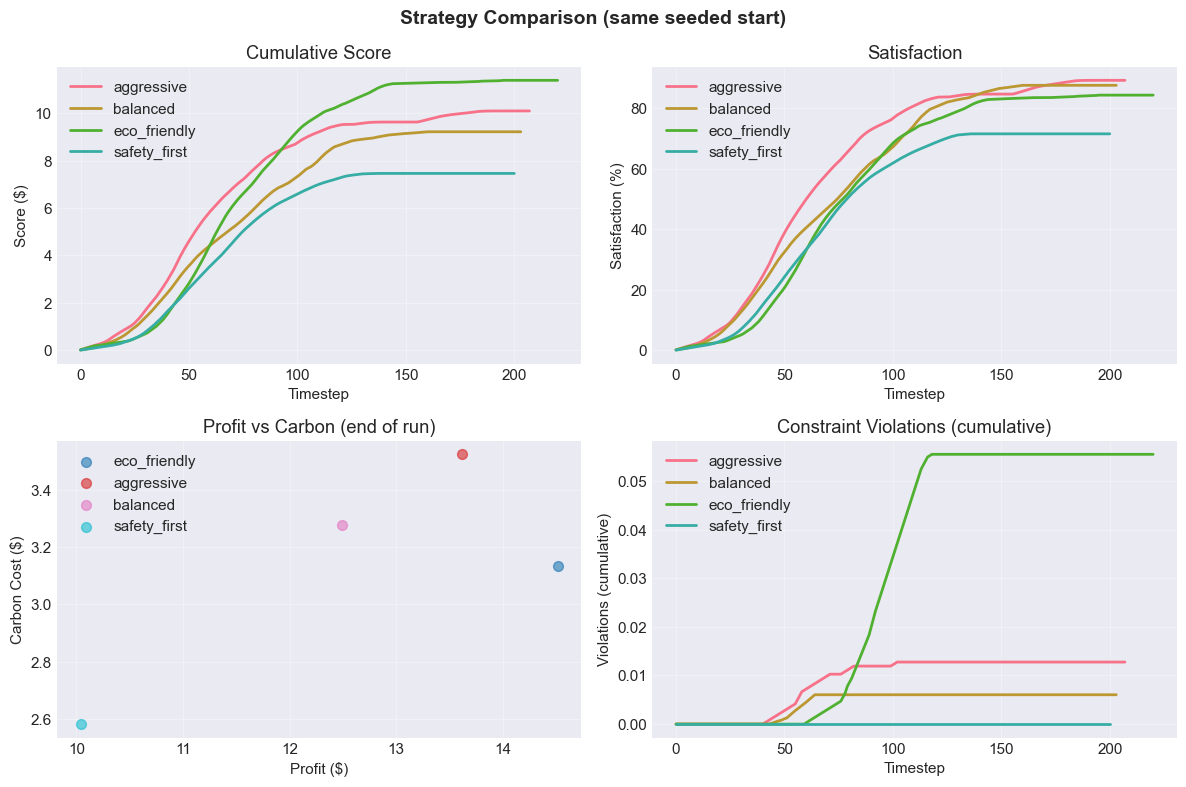

In [14]:

# Example usage (change seed/horizon as needed)
df_summary, runs = compare_strategies(gen, which=('balanced','aggressive','eco_friendly','safety_first'), seed=0, horizon=288)

#### How to interpret differences

- If a strategy’s $R_t$ and $S_t$ curves dominate another’s while also landing lower $C_T$ and lower $V_t$, it is clearly superior.
- Often, you’ll see trade-offs: aggressive charging may boost $R_t$ or $S_t$ but worsen $C_T$ or $V_t$; eco-friendly may reduce $C_T$ but slightly slow $S_t$; balanced tries to do well across all four.

## Section 5: Robustness Testing

Real-world systems face uncertainty in measurements and control. 

To probe robustness, we evaluate the policy under additive noise:
- Observation noise level $\epsilon$ perturbs elements of the observation vector:
  $$
  \tilde{\mathbf{o}}_t = \mathbf{o}_t + \boldsymbol{\xi}_t,\quad \boldsymbol{\xi}_t \sim \mathcal{N}(0, \epsilon^2 I).
  $$
- Action noise level $\eta$ perturbs the policy output before the environment applies it:
  $$
  \tilde{\mathbf{a}}_t = \mathbf{a}_t + \boldsymbol{\zeta}_t,\quad \boldsymbol{\zeta}_t \sim \mathcal{N}(0, \eta^2 I),
  $$
  followed by clipping to $[0,1]$ and any in-environment projection.

For each $(\epsilon, \eta)$ pair, we estimate episode metrics (e.g., mean return $\bar{R}$ and safety cost $\bar{C}$) across multiple episodes:
$$
\bar{R}(\epsilon, \eta) = \frac{1}{E}\sum_{e=1}^{E} \sum_{t=0}^{T_e-1} r_t^{(e)},\qquad
\bar{C}(\epsilon, \eta) = \frac{1}{E}\sum_{e=1}^{E} \sum_{t=0}^{T_e-1} c_t^{(e)}.
$$
Heatmaps of $\bar{R}$ and $\bar{C}$ over $(\epsilon,\eta)$ reveal sensitivity: flat heatmaps indicate robustness; steep gradients indicate fragility.


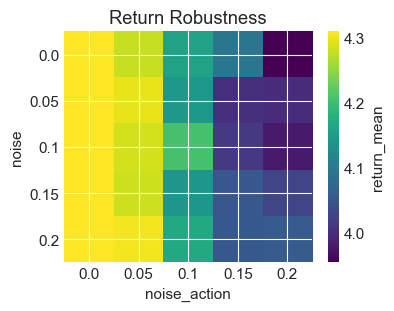

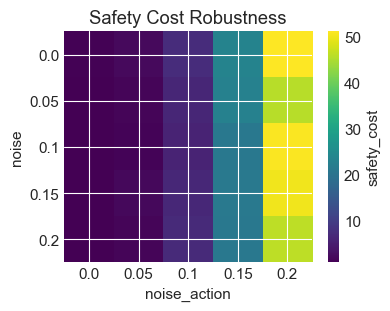

In [15]:
def robustness_analysis():
    """Comprehensive robustness testing using utilities"""
    from tutorials.utils import sweep_noise, plot_robustness_heatmap

    greedy_policy = lambda obs: np.where(obs['demands'] > 0, 0.8, 0.0)
    
    # Already uses sweep_noise correctly - just simplify the visualization
    full_sweep = sweep_noise(
        policy_fn=greedy_policy,
        make_env_fn=lambda **kw: EVChargingEnv(gen, project_action_in_env=True, **kw),
        Ns=[0.0, 0.05, 0.1, 0.15, 0.2],
        N_as=[0.0, 0.05, 0.1, 0.15, 0.2],
        episodes=3,
        show_progress=True  # default
    )
    
    # Use built-in visualization
    plot_robustness_heatmap(full_sweep, value='return_mean', title='Return Robustness')
    plot_robustness_heatmap(full_sweep, value='safety_cost', title='Safety Cost Robustness')
    
    # Print summary stats
    show("section: Robustness Summary")
    for metric in ['return_mean', 'safety_cost']:
        baseline = full_sweep[(full_sweep.noise == 0) & (full_sweep.noise_action == 0)][metric].iloc[0]
        worst = full_sweep[metric].min() if metric == 'return_mean' else full_sweep[metric].max()
        show(f"metric: {metric}: {baseline:.2f} → {worst:.2f} ({(worst-baseline)/baseline*100:+.1f}%)")

robustness_analysis()

['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


['profit', 'carbon_cost', 'excess_charge']


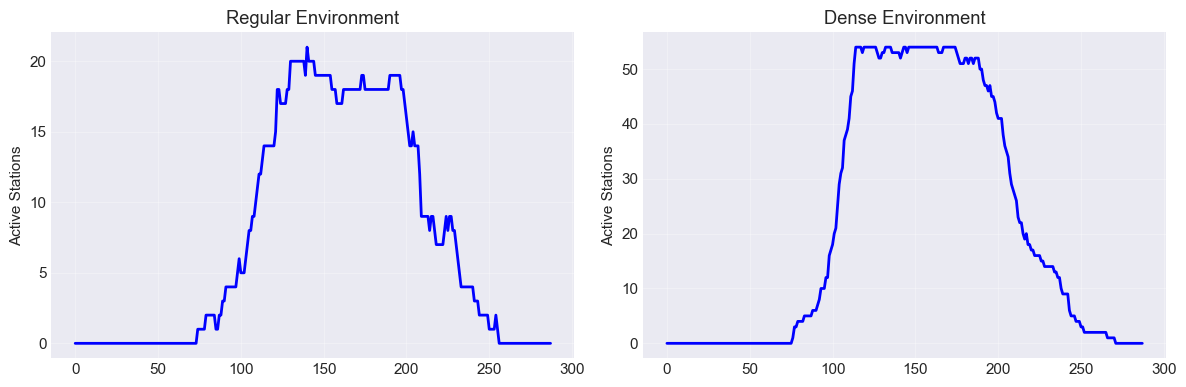

In [16]:
# 1. Compare environment configurations
def debug_environment_density():
    """Check if dense mode actually increases event density"""
    
    # Regular environment
    env_regular = EVChargingEnv(gen, project_action_in_env=True)
    
    # Dense environment
    env_dense = create_ev_env(flatten=False, dense_mode=True, density_multiplier=EVAL_CFG.density_multiplier)
    
    # Count active stations over time
    def count_activity(env, steps=288):
        obs, _ = env.reset(seed=42)
        active_counts = []
        for _ in range(steps):
            active = np.sum(obs['demands'] > 0)
            active_counts.append(active)
            obs, _, done, _, _ = env.step(np.zeros(env.num_stations))
            if done:
                break
        return np.array(active_counts)
    
    regular_activity = count_activity(env_regular)
    dense_activity = count_activity(env_dense)
    
    show("section: Environment Density Comparison")
    show_metrics({
        'Regular - Mean active stations': float(np.mean(regular_activity)),
        'Regular - % steps with activity': f"{100*np.mean(regular_activity > 0):.1f}%",
        'Dense - Mean active stations': float(np.mean(dense_activity)),
        'Dense - % steps with activity': f"{100*np.mean(dense_activity > 0):.1f}%",
        'Density increase': f"{np.mean(dense_activity)/max(np.mean(regular_activity), 0.01):.1f}x"
    })
    
    # Plot comparison
    quick_plot({
        'layout': '1x2', 'size': (12, 4),
        'plots': [
            {'type': 'line', 'x': np.arange(len(regular_activity)), 'y': regular_activity,
             'title': 'Regular Environment', 'ylabel': 'Active Stations'},
            {'type': 'line', 'x': np.arange(len(dense_activity)), 'y': dense_activity,
             'title': 'Dense Environment', 'ylabel': 'Active Stations'}
        ]
    })

# 2. Debug the satisfaction calculation
def debug_satisfaction_calculation():
    """Check why satisfaction shows 0% in strategy comparison"""
    
    env = create_ev_env(flatten=False, dense_mode=True)
    obs, _ = env.reset(seed=0)
    
    # Use seek to get to active period
    obs, _, _ = seek_to_active(env, key='demands', max_seek=400)
    
    # Run a few steps with greedy policy
    for step in range(10):
        demands_before = obs['demands'].copy()
        action = np.where(demands_before > 0, 0.8, 0.0)
        obs_next, reward, _, _, info = env.step(action)
        demands_after = obs_next['demands']
        
        # Calculate delivered energy
        delivered = np.maximum(0, demands_before - demands_after)
        # In debug_satisfaction_calculation, add:
        if 'reward_breakdown' in info:
            rb = info['reward_breakdown']
            show(f"Reward breakdown keys: {list(rb.keys())}")
            if 'delivered_energy' in rb or 'satisfaction' in rb:
                show(f"True metrics available: {rb}")
        show(f"section: Step {step}")
        show_metrics({
            'Active stations': int(np.sum(demands_before > 0)),
            'Total demand before': float(np.sum(demands_before)),
            'Total demand after': float(np.sum(demands_after)),
            'Delivered (proxy)': float(np.sum(delivered)),
            'Reward': float(reward),
            'Info keys': list(info.keys()) if isinstance(info, dict) else 'Not a dict'
        })
        
        obs = obs_next
        if np.sum(demands_before) == 0:
            break

# Run the debugging
debug_environment_density()
debug_satisfaction_calculation()

## Key Takeaways

- **Safety constraints fundamentally change the learning problem** - Unlike soft penalties, hard constraints create discontinuous feasible regions that require specialized handling (projection, barrier methods, or safe exploration strategies). This applies to any cyber-physical system with infrastructure limits.

- **Multi-objective optimization reveals preference trade-offs** - The inherent tension between competing objectives (profit/emissions/safety) cannot be resolved without explicit weighting choices. This is universal in real-world control where multiple stakeholders exist.

- **Robustness must be designed in, not added later** - Performance under noise/uncertainty often diverges significantly from nominal conditions. Testing with distribution shift should be part of the development cycle, not validation.

- **Domain knowledge shapes reward engineering** - The EV charging context provides natural structure (time-varying carbon intensity, departure deadlines) that informed agents can exploit. Similar temporal patterns exist in many infrastructure systems (power grids, traffic networks, data centers).

*The EV charging environment serves as a concrete instantiation of these principles, but the insights apply broadly to safe RL in cyber-physical systems where safety, robustness, and multi-agent coordination are critical.*

## What's Next

**Tutorial 02: Baselines and Trajectories** — Establish classical control strategies (Greedy, Random, MPC, Offline Optimal) and create performance benchmarks for comparing learning-based approaches.

## Acknowledgments

This tutorial series builds on:
- **[SustainGym](https://chrisyeh96.github.io/sustaingym/)** ([Yeh et al., NeurIPS 2023](https://openreview.net/forum?id=vZ9tA3o3hr)) — Base EV charging environment, adapted with robustness wrappers
- **[ACN-Data/Sim](https://github.com/zach401/acnportal)** ([Lee et al., 2019](https://doi.org/10.1145/3307772.3331015)) — Real charging session data from Caltech
- **[Robust-Gymnasium](https://github.com/SafeRL-Lab/Robust-Gymnasium)** ([Gu et al., ICLR 2025](https://openreview.net/forum?id=example)) — Robustness testing framework
- **[WattTime](https://www.watttime.org/)** / [CA SGIP](https://www.selfgenca.com/) — Marginal operating emissions rates data

**Survey:** Jin, M. (2025). [RL Meets the Power Grid](https://jinming.tech/assets/pdfs/2025-fnt-safe-rl-power-grid-survey.pdf). *Foundations and Trends in Electric Energy Systems*.  
*If you find these tutorials helpful, please consider citing the survey.*

**Note:** AI-assisted tools were used in developing these materials for clarity and code generation.
